In [1]:
pip install pyod shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 147 kB 4.9 MB/s 
     |████████████████████████████████| 575 kB 44.9 MB/s 
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=345a4af63a34a3992c6cf581568e3853a91ee1bb3b25bdd152c7be61cace0606
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
Successfully built pyod


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import warnings
from pyod.models.loda import LODA
import matplotlib.pyplot as plt
import seaborn as sn
import shap
from pickle import dump, load

#### Data Loading

In [3]:
df=pd.read_pickle('https://drive.google.com/uc?id=1hILz_vBupbUaEICj_Xgw933g5Har2hpW')

In [4]:
df.head()

,IDATE,LAT,LON,ELEVATION_m,PPT_mm,TMIN_c,TMEAN_c,TMAX_c,TDMEAN_c,lfmc_mean,lfmc_stdv,Mean_Sea_Level_Pressure,Mean_Station_Pressure,Mean_Wind_Speed,Maximum_Sustained_Wind_Speed,VPDMIN_hpa,VPDMAX_hpa
0,0.026572,0.256588,0.611242,0.252408,0.0,0.307359,0.377970,0.439271,0.350840,0.183593,0.234687,0.398496,0.917252,0.147619,0.200000,0.106533,0.234453
1,0.026572,0.306701,0.553827,0.267139,0.0,0.411255,0.431965,0.443320,0.487395,0.015900,0.099077,0.416040,0.913973,0.114286,0.211321,0.116937,0.207287
2,0.088574,0.177170,0.686698,0.265439,0.0,0.409091,0.460043,0.497976,0.449580,0.583804,0.335023,0.478697,0.928806,0.161905,0.290566,0.166875,0.245912
3,0.090345,0.650015,0.374516,0.460907,0.0,0.283550,0.280778,0.281377,0.279412,0.352868,0.308407,0.443609,0.790320,0.157143,0.222642,0.081149,0.144586
4,0.091231,0.113036,0.775809,0.553258,0.0,0.270563,0.269978,0.269231,0.250000,0.405914,0.409989,0.433584,0.953630,0.171429,0.211321,0.097794,0.118965


In [5]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=1, shuffle=False)
#Labels for PyOD 0 = inlier, 1 = outlier 
y_train=np.zeros(X_train.shape[0])
y_test=np.zeros(X_test.shape[0])
print("Train set data size : "+str(X_train.shape))
print("Test set data size : "+str(X_test.shape))

Train set data size : (5868, 17)
Test set data size : (1467, 17)


#### Hyper Parameter Tuning

In [6]:
# # Specify each parameter to find the best value for. Either a range of values or a set of predefined options can be specified for each parameter
# warnings.filterwarnings('ignore')
# space = {
#         'n_bins': hp.quniform('n_bins', 5, 200 , 5),
#         'n_random_cuts': hp.quniform('n_random_cuts', 50, 500 , 10)
#     }

# # The objective function is a combination of the learner and the parameters that you want to find the best values for. "model" can be changed to any learner 
# # The "accuracy" returned is the result of a standard accuracy score but doesn't involved cross validation but this code could be modified to do this
# def objective(space):
#     model = LODA(  n_bins = int(space['n_bins']), 
#                     n_random_cuts = int(space['n_random_cuts'])
#                  )
#     model.fit(X_train)
#     mean_prob = np.mean(model.predict_proba(X_train)[:,0])
#     # We aim to maximize accuracy, therefore we return it as a negative value
#     return {'loss': -mean_prob, 'status': STATUS_OK }
 
# # "fmin" minimises the objective function i.e. finds the set of parameters that results in the learner's best accuracy    
# trials = Trials()
# best = fmin(fn= objective,
#             space= space,
#             algo= tpe.suggest,
#             max_evals = 200,
#             trials= trials)
# warnings.filterwarnings(action='once')
# print(best)

#### Model Training

In [7]:
estimator=LODA(n_bins=160, n_random_cuts=90)
estimator.fit(X_train)

LODA(contamination=0.1, n_bins=160, n_random_cuts=90)

In [8]:
dump(estimator, open('07_CA_LODA.pkl', 'wb'))

#### Train set AVG Probability of Being Inlier

In [9]:
P1=estimator.predict_proba(X_train)[:,0]
print("Training set Mean :  ",round(np.mean(P1),6))
print("Training set STD :  ",round(np.std(P1),6))

Training set Mean :   0.923083
Training set STD :   0.071009


#### Test set AVG Probability of Being Inlier

In [10]:
P2=estimator.predict_proba(X_test)[:,0]
print("Test set Mean :  ",round(np.mean(P2),6))
print("Test set STD :  ",round(np.std(P2),6))

Test set Mean :   0.92087
Test set STD :   0.065412


#### All set AVG Probability of Being Inlier

In [11]:
P=np.append(P1,P2)
print("All Mean :  ",round(np.mean(P),6))
print("All STD :  ",round(np.std(P),6))

All Mean :   0.922641
All STD :   0.069931


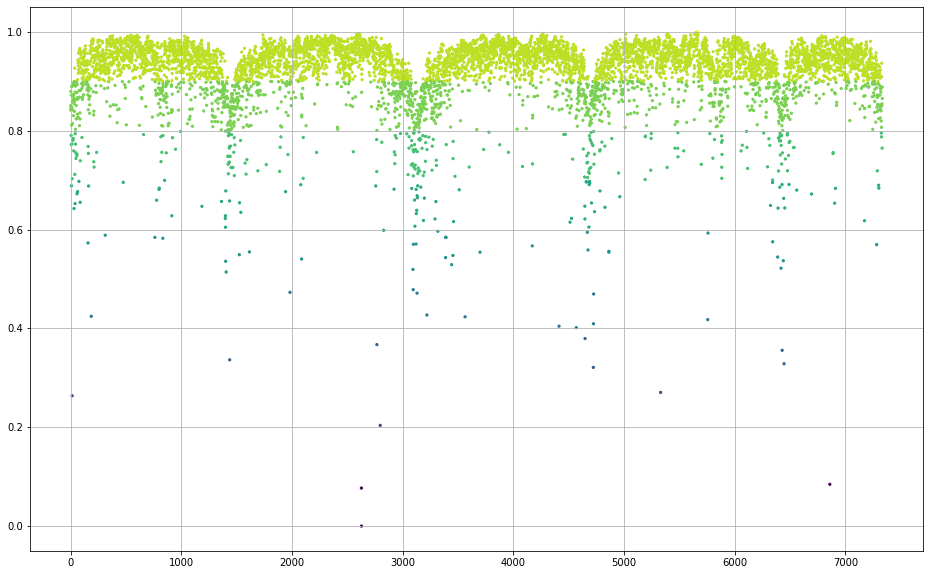

In [12]:
fig, ax = plt.subplots(figsize=(16,10))
im=ax.scatter(x=df.index,y=P,c=np.multiply(P,10).astype(int),s=5)
ax.grid(True)
plt.show()


In [13]:
#estimator.explain_outlier(1000)

#### Feature Importance

In [ ]:
warnings.filterwarnings('ignore')
#k_explainer = shap.KernelExplainer(estimator.predict, shap.sample(X_train, random_state=1))
k_explainer = shap.KernelExplainer(estimator.predict, shap.sample(X_train, nsamples=500, random_state=1))
X_test_sample=shap.sample(X_test,random_state=1)
k_shap_values = k_explainer.shap_values(X_test_sample) # More Sample Need more time
warnings.filterwarnings('once')

  0%|          | 0/100 [00:00<?, ?it/s]

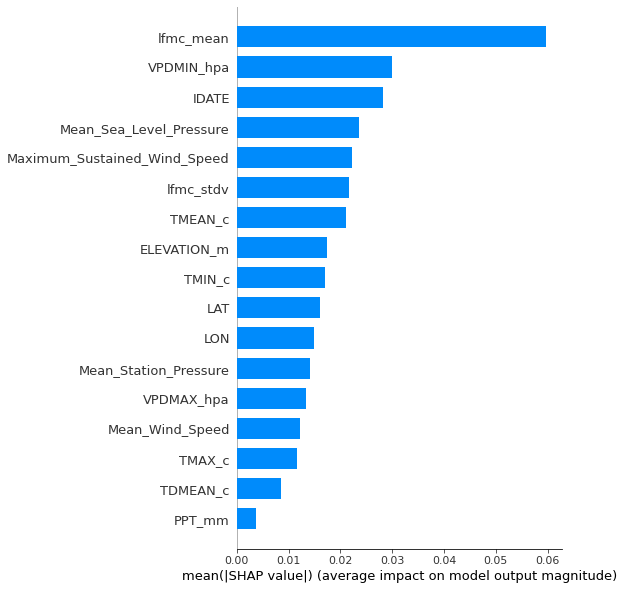

In [ ]:
shap.initjs()
shap.summary_plot(k_shap_values, X_test_sample, plot_type="bar")

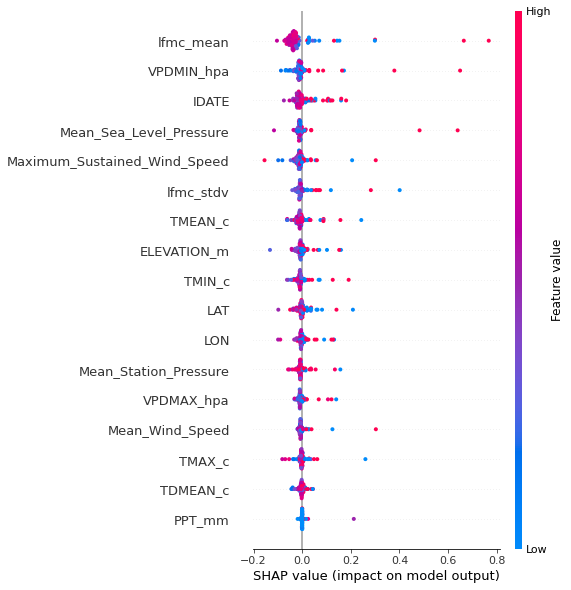

In [ ]:
shap.initjs()
shap.summary_plot(k_shap_values, X_test_sample)

In [ ]:
shap.initjs()
shap.force_plot(k_explainer.expected_value, k_shap_values, X_test_sample)

In [ ]:
feature_names = X_train.columns
rf_resultX = pd.DataFrame(k_shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
#shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
shap_importance

,col_name,feature_importance_vals
0,IDATE,0.028198
1,LAT,0.016097
2,LON,0.014919
3,ELEVATION_m,0.017455
4,PPT_mm,0.003699
5,TMIN_c,0.017087
6,TMEAN_c,0.020992
7,TMAX_c,0.011658
8,TDMEAN_c,0.008618
9,lfmc_mean,0.059714
